# Ignition delay computation
In this example, we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure.

The reactor (system) is simply an insulated box.

In [139]:
import pandas as pd
import numpy as np
import time

import cantera as ct

print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 2.6.0


### Import modules and set plotting defaults

In [140]:
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 120

plt.style.use("ggplot")
plt.style.use("seaborn-pastel")

### Define the gas
In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species [mechanism](https://combustion.llnl.gov/archived-mechanisms/alkanes/heptane-reduced-mechanism) by [Seier et al. 2000, Proc. Comb. Inst](http://dx.doi.org/10.1016/S0082-0784&#40;00&#41;80610-4). 

In [141]:
gas = ct.Solution("./Jerzembeck.cti")
gas2 = ct.Solution("./Jerzembeck.cti")

### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [142]:
# Define the reactor temperature and pressure
reactor_temperature = 800  # Kelvin
reactor_pressure = 101325  # Pascals

gas.TP = reactor_temperature, reactor_pressure
gas2.TP = 1500, ct.one_atm
# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel="IXC8H18", oxidizer={"o2": 1.0, "n2": 3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
A=0.0172
V=0.000212
env = ct.Reservoir(gas2)

r = ct.IdealGasReactor(contents=gas, name="Batch Reactor", volume=V)
w = ct.Wall(r,env,A=A,U=0.5*10**6)

reactor_network = ct.ReactorNet([r])


# use the above list to create a DataFrame
time_history = ct.SolutionArray(gas, extra="t")

### Define useful functions

In [143]:
def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

In [144]:
reference_species = "OH"

# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 50
t = 0
flag = False
counter = 1
t_total = []
ts = []
heat_release = []
temp_history = []
heat_t=[]
T_t=[]
t10=[]
temp10 = []
while t < estimated_ignition_delay_time:
    t = reactor_network.step()
    ts.append(counter)
    heat_release.append(-np.dot(gas.net_rates_of_progress,gas.delta_enthalpy)*V)
    temp_history.append(r.thermo.state.T[0])
    t_total.append(t)
    #heat = r.mass * r.enthalpy_mass
    #print(heat)
    if not counter % 10:
        
        T_t.append(r.thermo.state.T[0])
        t10.append(t)
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(r.thermo.state, t=t)
        heat_t.append(-np.dot(gas.net_rates_of_progress,gas.delta_enthalpy)*V)
        temp10.append(r.thermo.state.T[0])
        
        # heat_release.append(np.dot(gas.net_rates_of_progress,gas.delta_enthalpy))
        

        if r.thermo.state.T[0] - reactor_temperature > 500 and flag == False:
            print('Ignition delay is '+ str(t) + " s")
            flag = True
        #heat_release = np.dot(r.thermo.state.net_rates_of_progress,r.delta_enthalpy)
        
    counter += 1

    

# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)

# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")
# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
#time_history.write_csv("time_history.csv", cols=('T', 'P', 'X', 'net_rates_of_progress'))



Ignition delay is 1.569007381918055e-05 s
Computed Ignition Delay: 1.148e-04 seconds. Took 0.53s to compute


## Plot the result

### Figure illustrating the definition of ignition delay

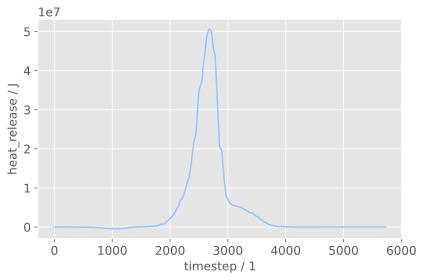

In [145]:
plt.plot(ts,heat_release)
plt.xlabel("timestep / 1")
plt.ylabel("heat_release / J")
plt.show()

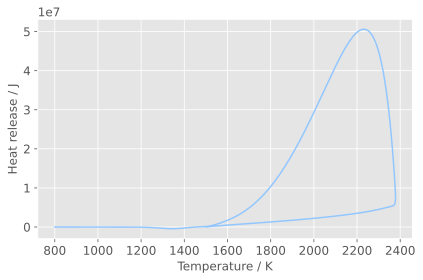

In [146]:
plt.figure()
# plt.plot(time_history.t, time_history(reference_species).Y, "-o")
# plt.xlabel("Time (s)")
# plt.ylabel("$Y_{OH}$")
plt.plot(temp_history,heat_release)
plt.xlabel('Temperature / K')
plt.ylabel('Heat release / J')
plt.show()
#plt.xlim([0, 0.05])
# plt.arrow(
#     0,
#     0.008,
#     tau,
#     0,
#     width=0.0001,
#     head_width=0.0005,
#     head_length=0.001,
#     length_includes_head=True,
#     color="r",
#     shape="full",
# )
# plt.annotate(
#     r"$Ignition Delay: \tau_{ign}$", xy=(0, 0), xytext=(0.01, 0.0082), fontsize=16
# );

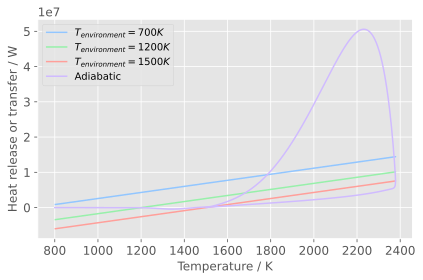

In [147]:
U = 0.5*10**6
q = heat_release
qT1 = []
qT2 = []
qT3 = []
# CASE I
TR1 = 700

# CASE II
TR2 = 1200

# CASE III
TR3 = 1500
for i in range(len(T_t)):
    qT1.append((temp10[i]-TR1)*A*U)
    qT2.append((temp10[i]-TR2)*A*U)
    qT3.append((temp10[i]-TR3)*A*U)


plt.plot(temp10, qT1, label='$T_{environment}=700K$')
plt.plot(temp10, qT2, label='$T_{environment}=1200K$')
plt.plot(temp10, qT3, label='$T_{environment}=1500K$' )

plt.plot(temp_history, heat_release, label = 'Adiabatic')
plt.legend()
plt.xlabel('Temperature / K')
plt.ylabel('Heat release or transfer / W')
#plt.ylim([0, 9*10**10])
plt.show()
